# OBTENCION DE DATOS
**IMPORTAR LIBRERIAS Y OBTENER EL DATASET**

En primer lugar, importaremos las siguientes librerias necesarias para el analisis y procederemos a leer y mostrar el dataset.

In [3]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import display

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.0f}'.format
warnings.filterwarnings('ignore')

In [6]:
url ='https://raw.githubusercontent.com/simonzanetti/2023.2-SysArmy-IT-Salaries-Survey/main/cleaned_dataset.csv'
salaries = pd.read_csv(url)

# EDA: ANALISIS  MONOVARIABLE


**FUNCIONES AUXILIARES**

In [7]:
def boxplot_values(column):
    percentiles = np.percentile(salaries[column], [25, 50, 75])
    Q1 = percentiles[0]
    Q3 = percentiles[2]
    IQR = Q3 - Q1
    max_fence = Q3 + 1.5*IQR
    min_fence = Q1 - 1.5*IQR
    return IQR,max_fence,min_fence,percentiles

def boxplot_plotting_values(column_name, subplot):
    IQR, max_fence, min_fence, percentiles = boxplot_values(column_name)
    if min_fence <= 0:
        min_fence = 0
    if min_fence <= min(salaries[column_name]):
        min_fence = min(salaries[column_name])
    else:
        min_fence = percentiles[0] - 1.5 * IQR

    subplot.annotate(f'{int(percentiles[0])}', xy=(percentiles[0], 0), xytext=(percentiles[0] - 2, 0.45), fontsize=7)
    subplot.annotate(f'{int(percentiles[1])}', xy=(percentiles[1], 0), xytext=(percentiles[1], 0.45), fontsize=7)
    subplot.annotate(f'{int(percentiles[2])}', xy=(percentiles[2], 0), xytext=(percentiles[2] + 2, 0.45), fontsize=7)

    for i, outlier_limit in enumerate([min_fence, max_fence]):
        subplot.annotate(f'{int(outlier_limit)}', xy=(outlier_limit, 0), xytext=(outlier_limit - 1.5, 0.25))

**EMPLOYEE**

> **work_province**: 
El 49% de los encuestados proviene de CABA y casi el 70% proviene solo de CABA y Buenos Aires. Las 5 provincias con mas encuestados(CABA, Buenos Aires, Córdoba, Santa Fe y Mendoza) representan casi el 90% de los encuestados.  



> **age**: 
El rango de edades va desde 18 a 455. Se utilizo la tecnica de IQR y z-score para filtar los datos, obteniendo un rango grueso de edades entre 18 y 55 años (limite IQR) y con 104 edades entre 55 y 70 (limite IQR/z-score) que fueron dejadas en observacion.
La mayor concentracion de edades se da entre 28 y 39 años, con una media de 33 años y con una moda de 27 años.

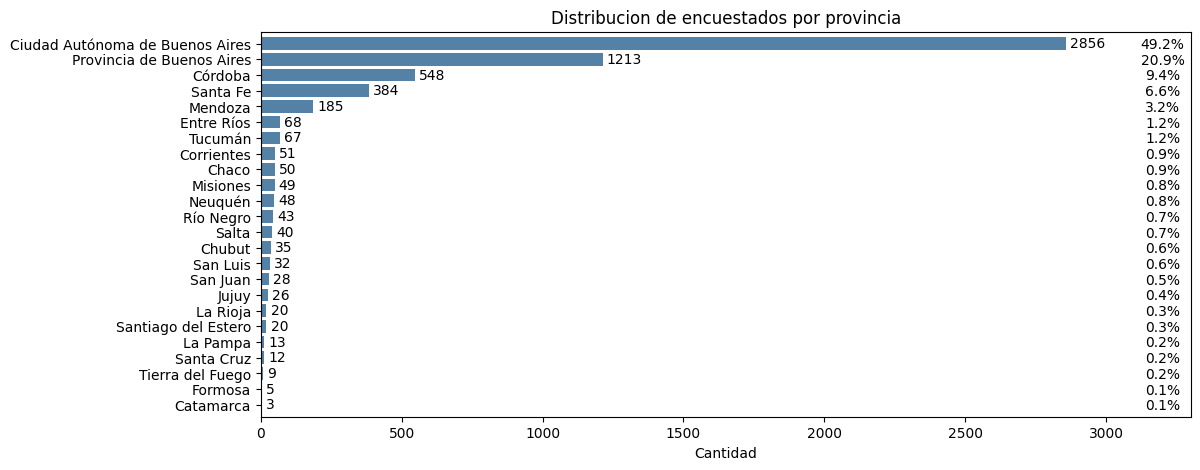

In [8]:
#WORK_PROVINCE
fig = plt.figure(figsize=(12, 5))
ax = sns.countplot(y=salaries['work_province'], color='steelblue', order=df["work_province"].value_counts().index)
plt.title("Distribucion de encuestados por provincia",loc='center')
plt.xlabel("Cantidad")
plt.ylabel('')
#plt.xscale('log')
ax.set_xlim(0,3300)
ax.bar_label(ax.containers[0], padding=3)
ax.margins(y=0.015)

total = len(salaries)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / total)
    ax.annotate(percentage, (3200, (p.get_y() + p.get_height() / 2) + 0.5), ha='center', va='bottom', fontsize=10)

<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

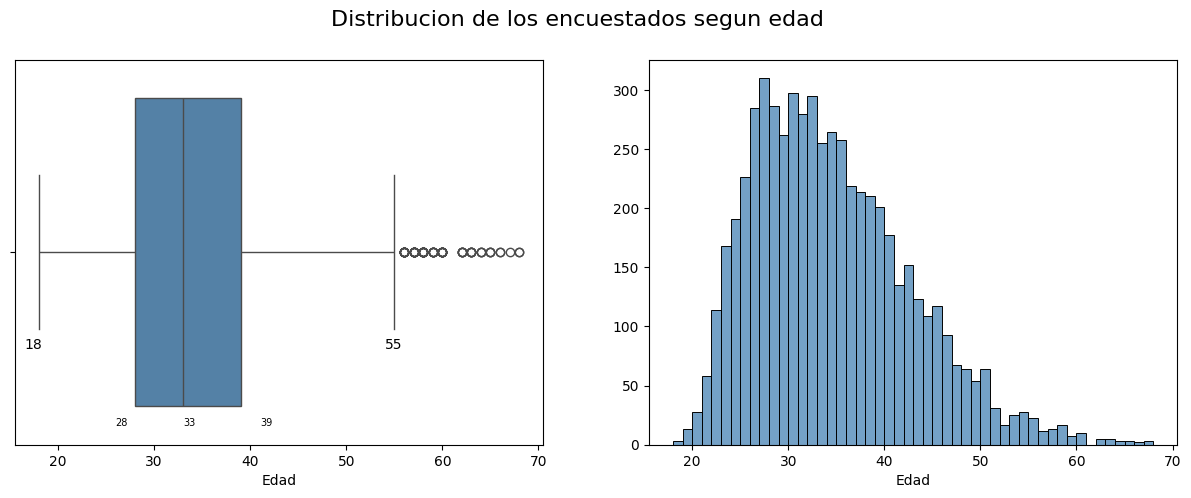

In [9]:
#AGE
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
ax1 = sns.boxplot(salaries[stats.zscore(salaries['age']) < 3],x ='age', color='steelblue',ax=axes[0])
axes[0].set_xlabel('Edad')
boxplot_plotting_values('age',ax1)

ax2 = sns.histplot(salaries[stats.zscore(salaries['age']) < 3],x ='age', color='steelblue',ax=axes[1],binwidth=1)
axes[1].set_ylabel('')
axes[1].set_xlabel('Edad')
#display(salaries[(salaries['age'] >= 55) & (salaries['age'] <= 70)].shape)

fig.suptitle('Distribucion de los encuestados segun edad', fontsize=16)
plt.tight_layout

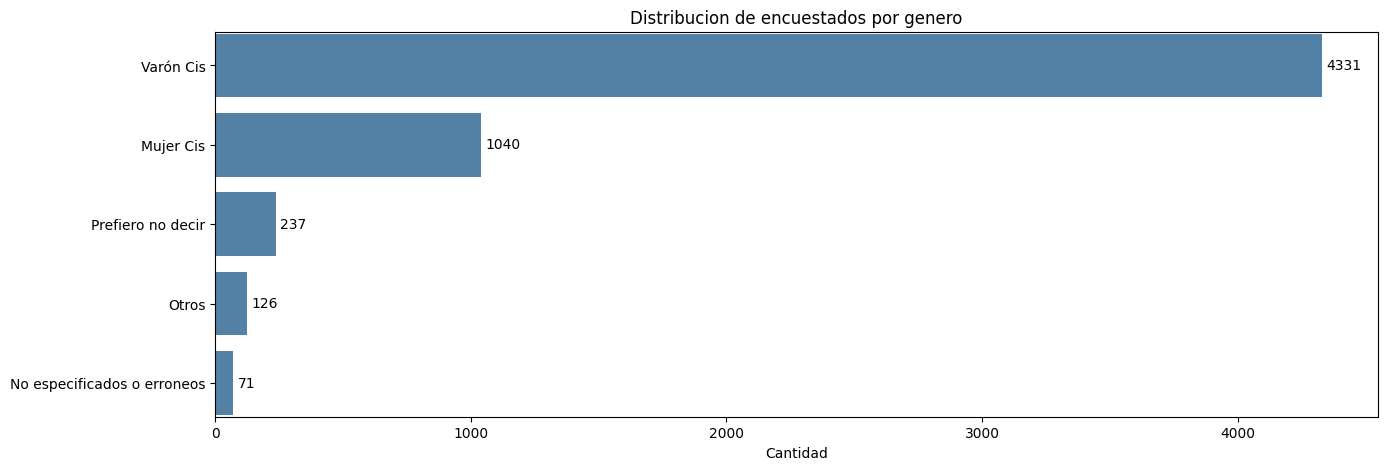

In [52]:
#GENDER
fig = plt.figure(figsize=(15, 5))
ax = sns.countplot(y=salaries['gender'], color='steelblue', order=salaries["gender"].value_counts().index)
plt.title("Distribucion de encuestados por genero",loc='center')
plt.xlabel("Cantidad")
plt.ylabel('')
plt.bar_label(ax.containers[0], padding=3, fontsize = 10)
ax.margins(y=0.005)

**WORK**

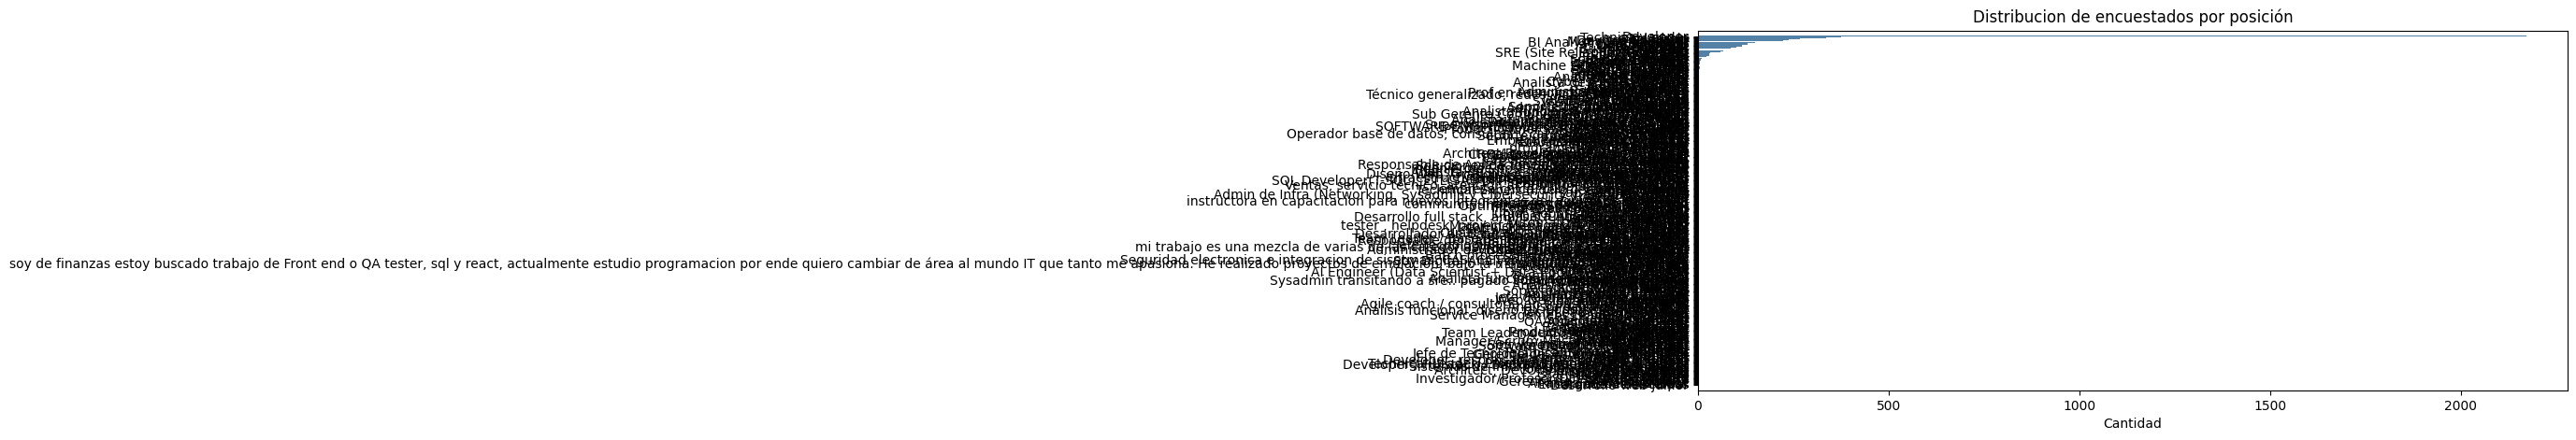

In [ ]:
#WORK_TITLE
fig = plt.figure(figsize=(15, 5))
ax = sns.countplot(y=salaries['work_title'], color='steelblue', order=df["work_title"].value_counts().index)
plt.title("Distribucion de encuestados por posición",loc='center')
plt.xlabel("Cantidad")
plt.ylabel('')
#ax.bar_label(ax.containers[0], padding=3)
ax.margins(y=0.015)

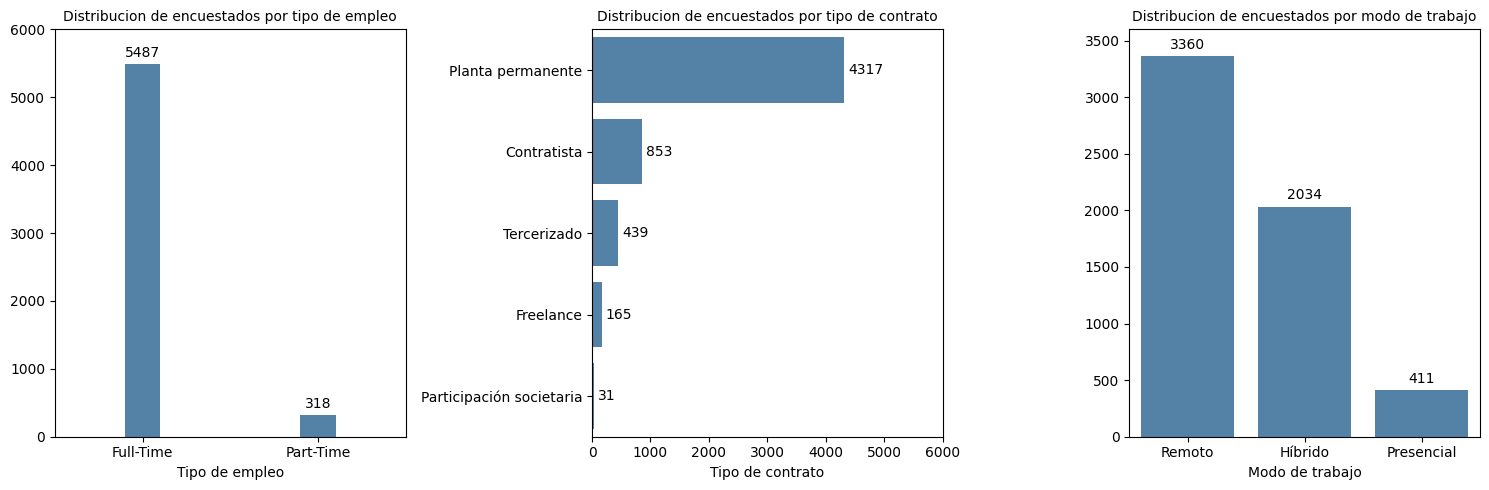

In [55]:
# WORK_DEDICATION, WORK_CONTRACT_TYPE AND WORK_MODE
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ax1 = sns.countplot(x=salaries['work_type'], color='steelblue',width=0.2,ax=axes[0])
axes[0].set_xlabel("Tipo de empleo")
axes[0].set_ylabel('')
axes[0].set_title("Distribucion de encuestados por tipo de empleo", fontsize=10)
axes[0].set_ylim(0, 6000)
ax1.bar_label(ax1.containers[0], padding=3)

ax2 = sns.countplot(y=salaries['work_contract_type'], color='steelblue',order=salaries["work_contract_type"].value_counts().index,ax=axes[1])
axes[1].set_title("Distribucion de encuestados por tipo de contrato", fontsize=10)
axes[1].set_xlabel("Tipo de contrato")
axes[1].set_ylabel('')
axes[1].set_xlim(0, 6000)
ax2.bar_label(ax2.containers[0], padding=3)


ax3 = sns.countplot(x=salaries['work_mode'], color='steelblue',order=salaries["work_mode"].value_counts().index,ax=axes[2])
axes[2].set_title("Distribucion de encuestados por modo de trabajo", fontsize=10)
axes[2].set_xlabel("Modo de trabajo")
axes[2].set_ylabel('')
axes[2].set_ylim(0, 3600)
ax3.bar_label(ax3.containers[0], padding=3)

plt.tight_layout()

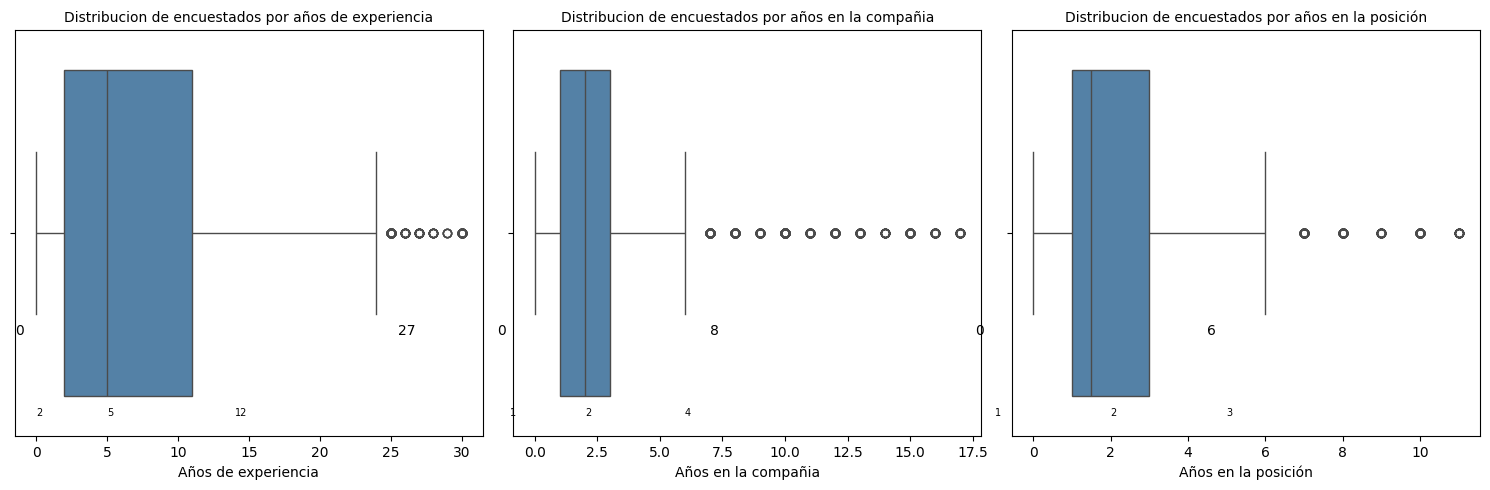

In [59]:
#YEARS_EXPERIENCE, YEARS_IN_COMPANY AND YEARS_IN_POSITION
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

def years (column,subplot,xlabel,title):
    sns.boxplot(salaries[stats.zscore(salaries[column]) < 3],x =column, color='steelblue',ax=subplot)
    subplot.set_xlabel(xlabel)
    subplot.set_label('')
    subplot.set_title(title, fontsize=10)
    plt.tight_layout()

    boxplot_plotting_values(column,subplot)

years('years_experience',axes[0],'Años de experiencia',"Distribucion de encuestados por años de experiencia")
years('years_in_company',axes[1], 'Años en la compañia', "Distribucion de encuestados por años en la compañia")
years('years_in_position',axes[2], 'Años en la posición', "Distribucion de encuestados por años en la posición")

**COMPANY**

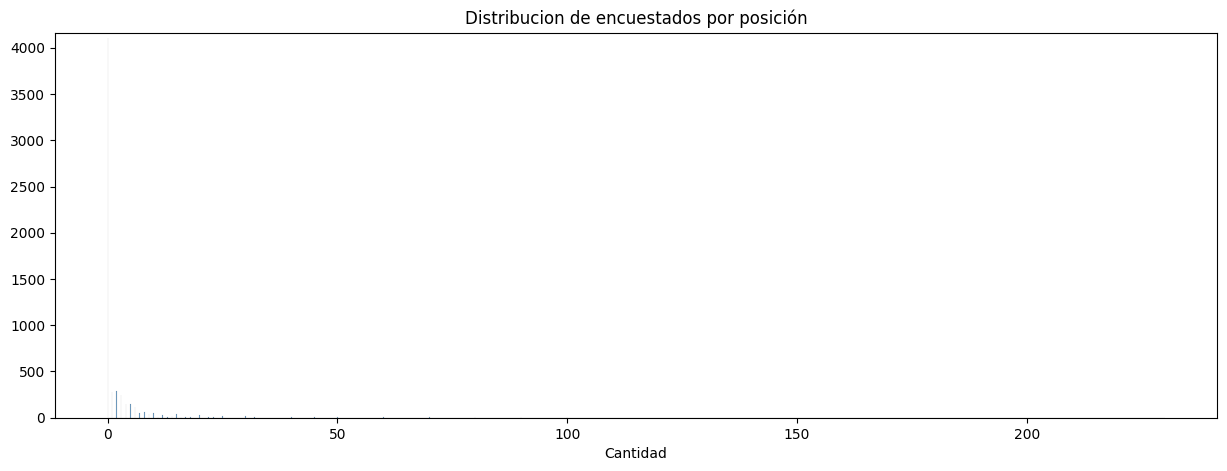

In [76]:
#PEOPLE_IN_CHARGE
fig = plt.figure(figsize=(15, 5))
ax = sns.countplot(salaries['people_in_charge'], color='steelblue')
plt.title("Distribucion de encuestados por posición",loc='center')
plt.xlabel("Cantidad")
plt.ylabel('')
#ax.bar_label(ax.containers[0], padding=3)
ax.margins(y=0.015)

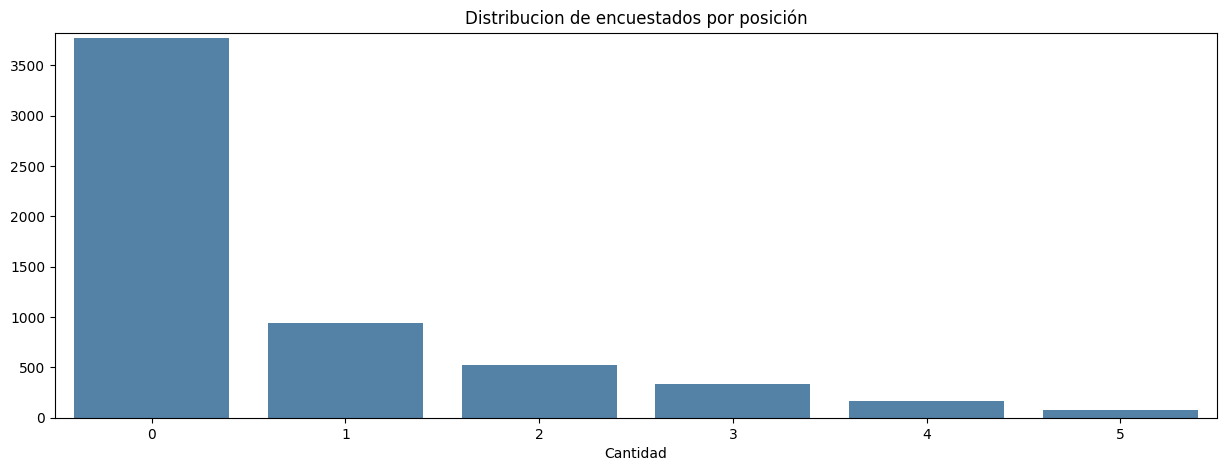

In [78]:
#OFFICE_DAYS_NUMBER(HYBRID)
fig = plt.figure(figsize=(15, 5))
ax = sns.countplot(x = salaries['office_days_number(hybrid)'], color='steelblue')
plt.title("Distribucion de encuestados por posición",loc='center')
plt.xlabel("Cantidad")
plt.ylabel('')
#ax.bar_label(ax.containers[0], padding=3)
ax.margins(y=0.015)

<Axes: xlabel='count', ylabel='work_place_satisfaction'>

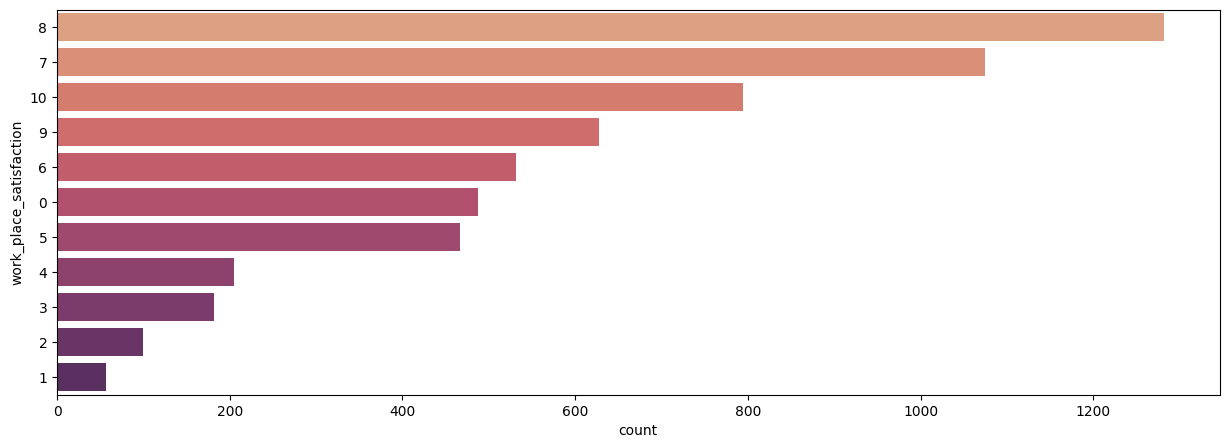

In [64]:
fig = plt.figure(figsize=(15, 5))
sns.countplot(y=salaries['work_place_satisfaction'], palette='flare',order=salaries['work_place_satisfaction'].value_counts().index)

[Text(2, 0, '3018')]

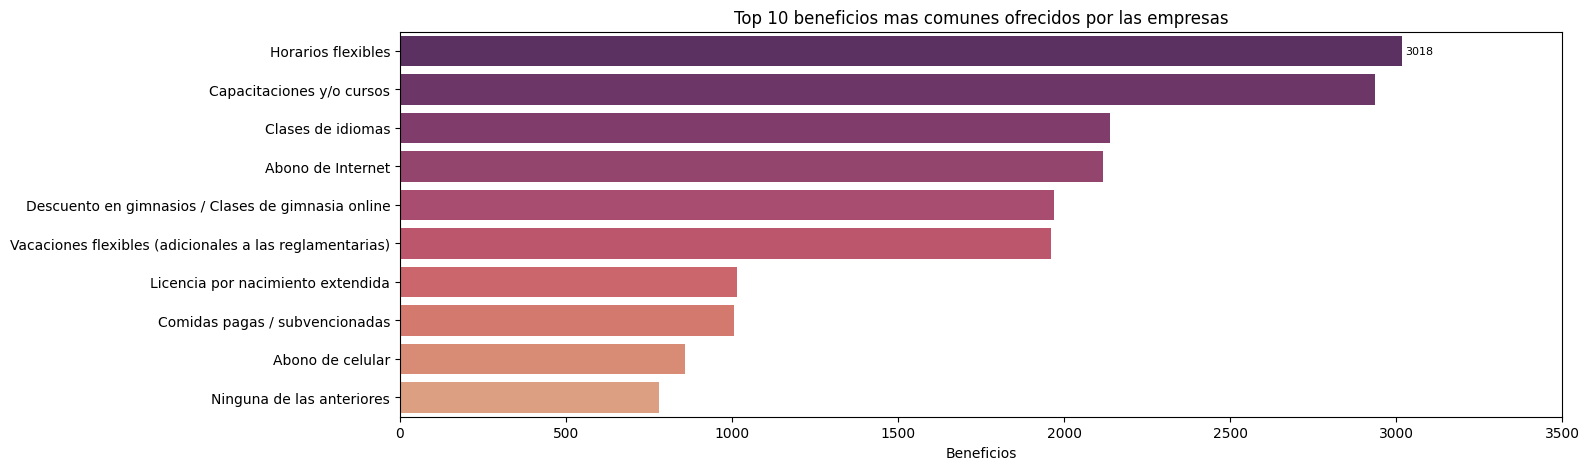

In [69]:
#WORK_PLACE_BENEFITS
fig = plt.figure(figsize=(15, 5))
ax = sns.barplot(data=benefits_count.head(10),y='item',x='counts', palette='flare' + "_r")
plt.title('Top 10 beneficios mas comunes ofrecidos por las empresas',)
plt.xlabel('Beneficios')
plt.ylabel('')
plt.xlim(0,3500)
plt.bar_label(ax.containers[0], padding=2, fontsize=8)

**SALARIES**

In [ ]:
#LAST_MONTH_GROSS_SALARY
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
filtered_gross_salary = salaries[stats.zscore(salaries['last_month_gross_salary']) < 3.5]
ax = sns.histplot(data=filtered_gross_salary,x='last_month_gross_salary', color='steelblue',ax=axes[0],bins=35)
ax.ticklabel_format(style='plain', axis='both')
ax.bar_label(ax.containers[0], padding=3,fontsize=6)
axes[0].set_title("Distribucion de encuestados por percepción de salario bruto", fontsize=16)

#LAST_MONTH_NET_SALARY
filtered_net_salary = salaries[stats.zscore(salaries[~np.isnan(salaries['last_month_net_salary'])])]
print(filtered_net_salary)
ay = sns.histplot(data=filtered_net_salary,x='last_month_net_salary', color='steelblue',ax=axes[1],bins=35)
ay.ticklabel_format(style='plain', axis='both')
axes[1].set_title("Distribucion de encuestados por tipo de empleo", fontsize=16)

plt.tight_layout()

[Text(3, 0, '3865'), Text(3, 0, '379'), Text(3, 0, '773'), Text(3, 0, '788')]

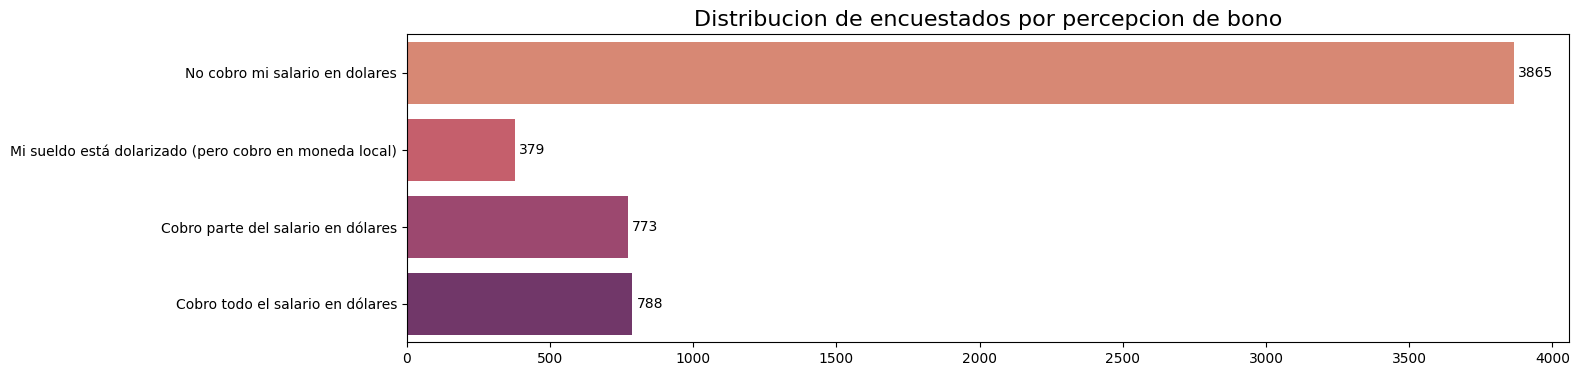

In [ ]:
#SALARY_IN_USD
fig = plt.figure(figsize=(15, 4))
ax = sns.countplot(y=salaries['salary_in_usd'],palette='flare',order=['No cobro mi salario en dolares',
                                                                      'Mi sueldo está dolarizado (pero cobro en moneda local)',
                                                                      'Cobro parte del salario en dólares',
                                                                      'Cobro todo el salario en dólares'
                                                                      ])
plt.xlabel('')
plt.ylabel('')
plt.title('Distribucion de encuestados por percepcion de bono', fontsize=16)
ax.bar_label(ax.containers[0], padding=3)

[Text(3, 0, '3293'),
 Text(3, 0, '759'),
 Text(3, 0, '755'),
 Text(3, 0, '816'),
 Text(3, 0, '182')]

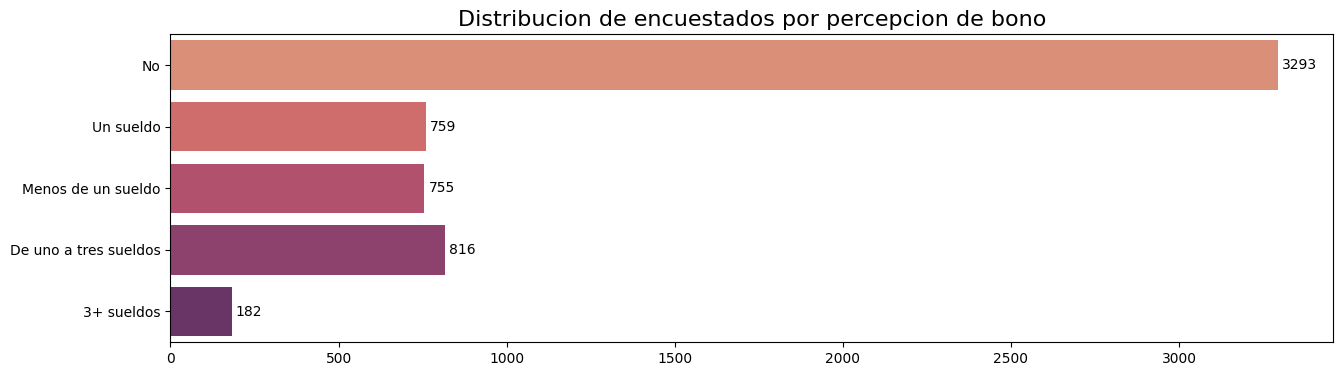

In [ ]:
#SALARY_HAS_BONUS
fig = plt.figure(figsize=(15, 4))
ax = sns.countplot(y=salaries['salary_has_bonus'],palette='flare')
plt.xlabel('')
plt.ylabel('')
plt.title('Distribucion de encuestados por percepcion de bono', fontsize=16)
ax.bar_label(ax.containers[0], padding=3)

In [ ]:
#SALARY_HAS_BONUS (NORMALIZAR)

In [ ]:
#WORK_BENEFITS (NORMALIZAR)

In [1]:
#SALARY_SATISFACTION
print(salaries['salary_satisfaction'].unique())
fig = plt.figure(figsize=(15, 4))
ax = sns.countplot(y=salaries['salary_satisfaction'],palette='flare',order=['Muy insatisfecho','Escasamente satisfecho',
                                                                            'Ampliamente satisfecho','Muy satisfecho'])
plt.xlabel('')
plt.ylabel('')
plt.title('Distribucion de encuestados por satisfaccion salarial', fontsize=16)
ax.bar_label(ax.containers[0], padding=3)

NameError: name 'salaries' is not defined

**TOOLS**

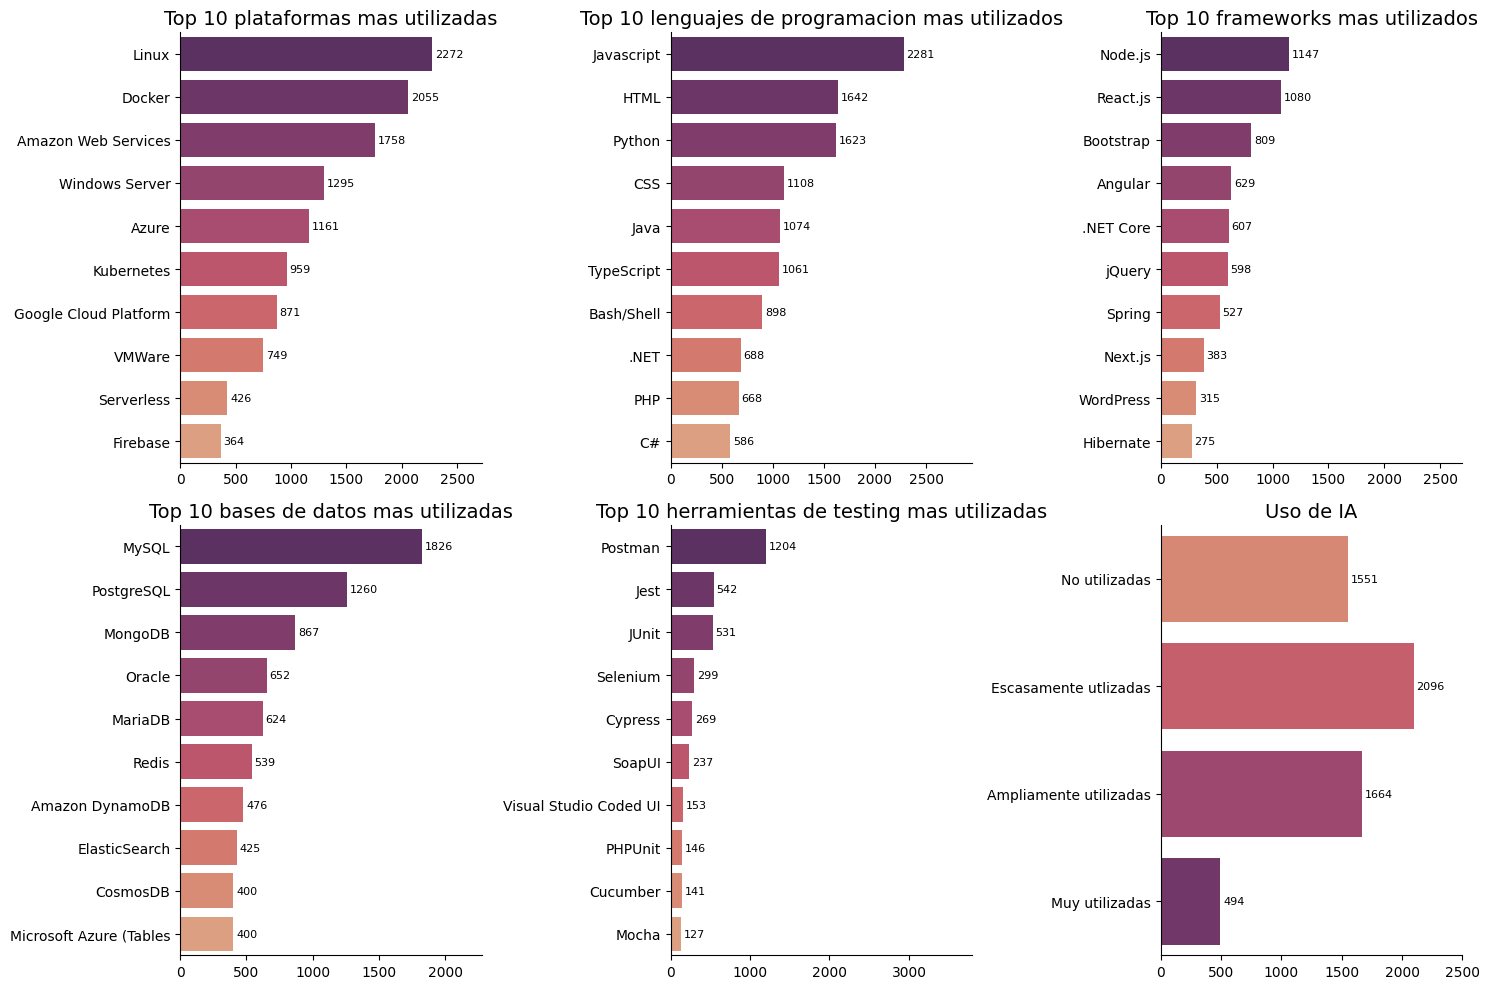

In [215]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
sns.despine(top=True)
def plotting_tools(df,subplot,title):
    ax = sns.barplot(data=df[~df['item'].str.contains(r'Ningun[ao] de l[ao]s anteriores|etc\)|\bSQL\b')].head(10),y='item',x='counts', ax=subplot, palette='flare' + "_r")
    subplot.set_xlabel('')
    subplot.set_ylabel('')
    subplot.set_title('Top 10 ' + title, fontsize=14)
    subplot.set_xlim(0, df.iloc[0,1] + 450)
    ax.bar_label(ax.containers[0], padding=2, fontsize=8)

plotting_tools(platforms_count,axes[0,0],'plataformas mas utilizadas')
plotting_tools(programming_languages_count,axes[0,1],'lenguajes de programacion mas utilizados')
plotting_tools(frameworks_count,axes[0,2],'frameworks mas utilizados')
plotting_tools(databases_count,axes[1,0],'bases de datos mas utilizadas')
plotting_tools(qa_testing_tools_count,axes[1,1],'herramientas de testing mas utilizadas')

ax = sns.countplot(y=salaries['AI_tools_use'], ax=axes[1,2],palette='flare')
axes[1,2].set_xlabel('')
axes[1,2].set_ylabel('')
axes[1,2].set_title('Uso de IA', fontsize=14)
axes[1,2].set_xlim(0, 2500)
ax.bar_label(ax.containers[0], padding=2, fontsize=8)

plt.tight_layout()

**STUDIES**

Text(0, 0.5, '')

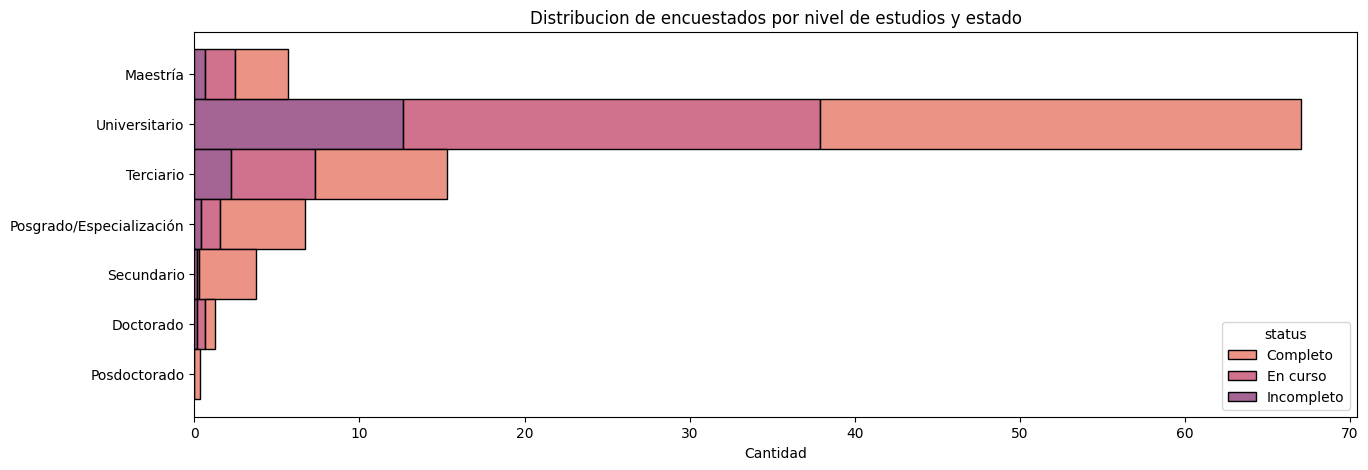

In [27]:
#HIGHEST_LEVEL_STUDIES AND STATUS
fig = plt.figure(figsize=(15, 5))
ax = sns.histplot(salaries[salaries["highest_level_studies"] != 'Prefiero no responder'],y='highest_level_studies', palette='flare',hue='status',multiple='stack',stat='percent')
plt.title("Distribucion de encuestados por nivel de estudios y estado",loc='center')
plt.xlabel("Cantidad")
plt.ylabel('')


Text(150, 8, 'Cantidad de encuestados en esta categoria: 1818')

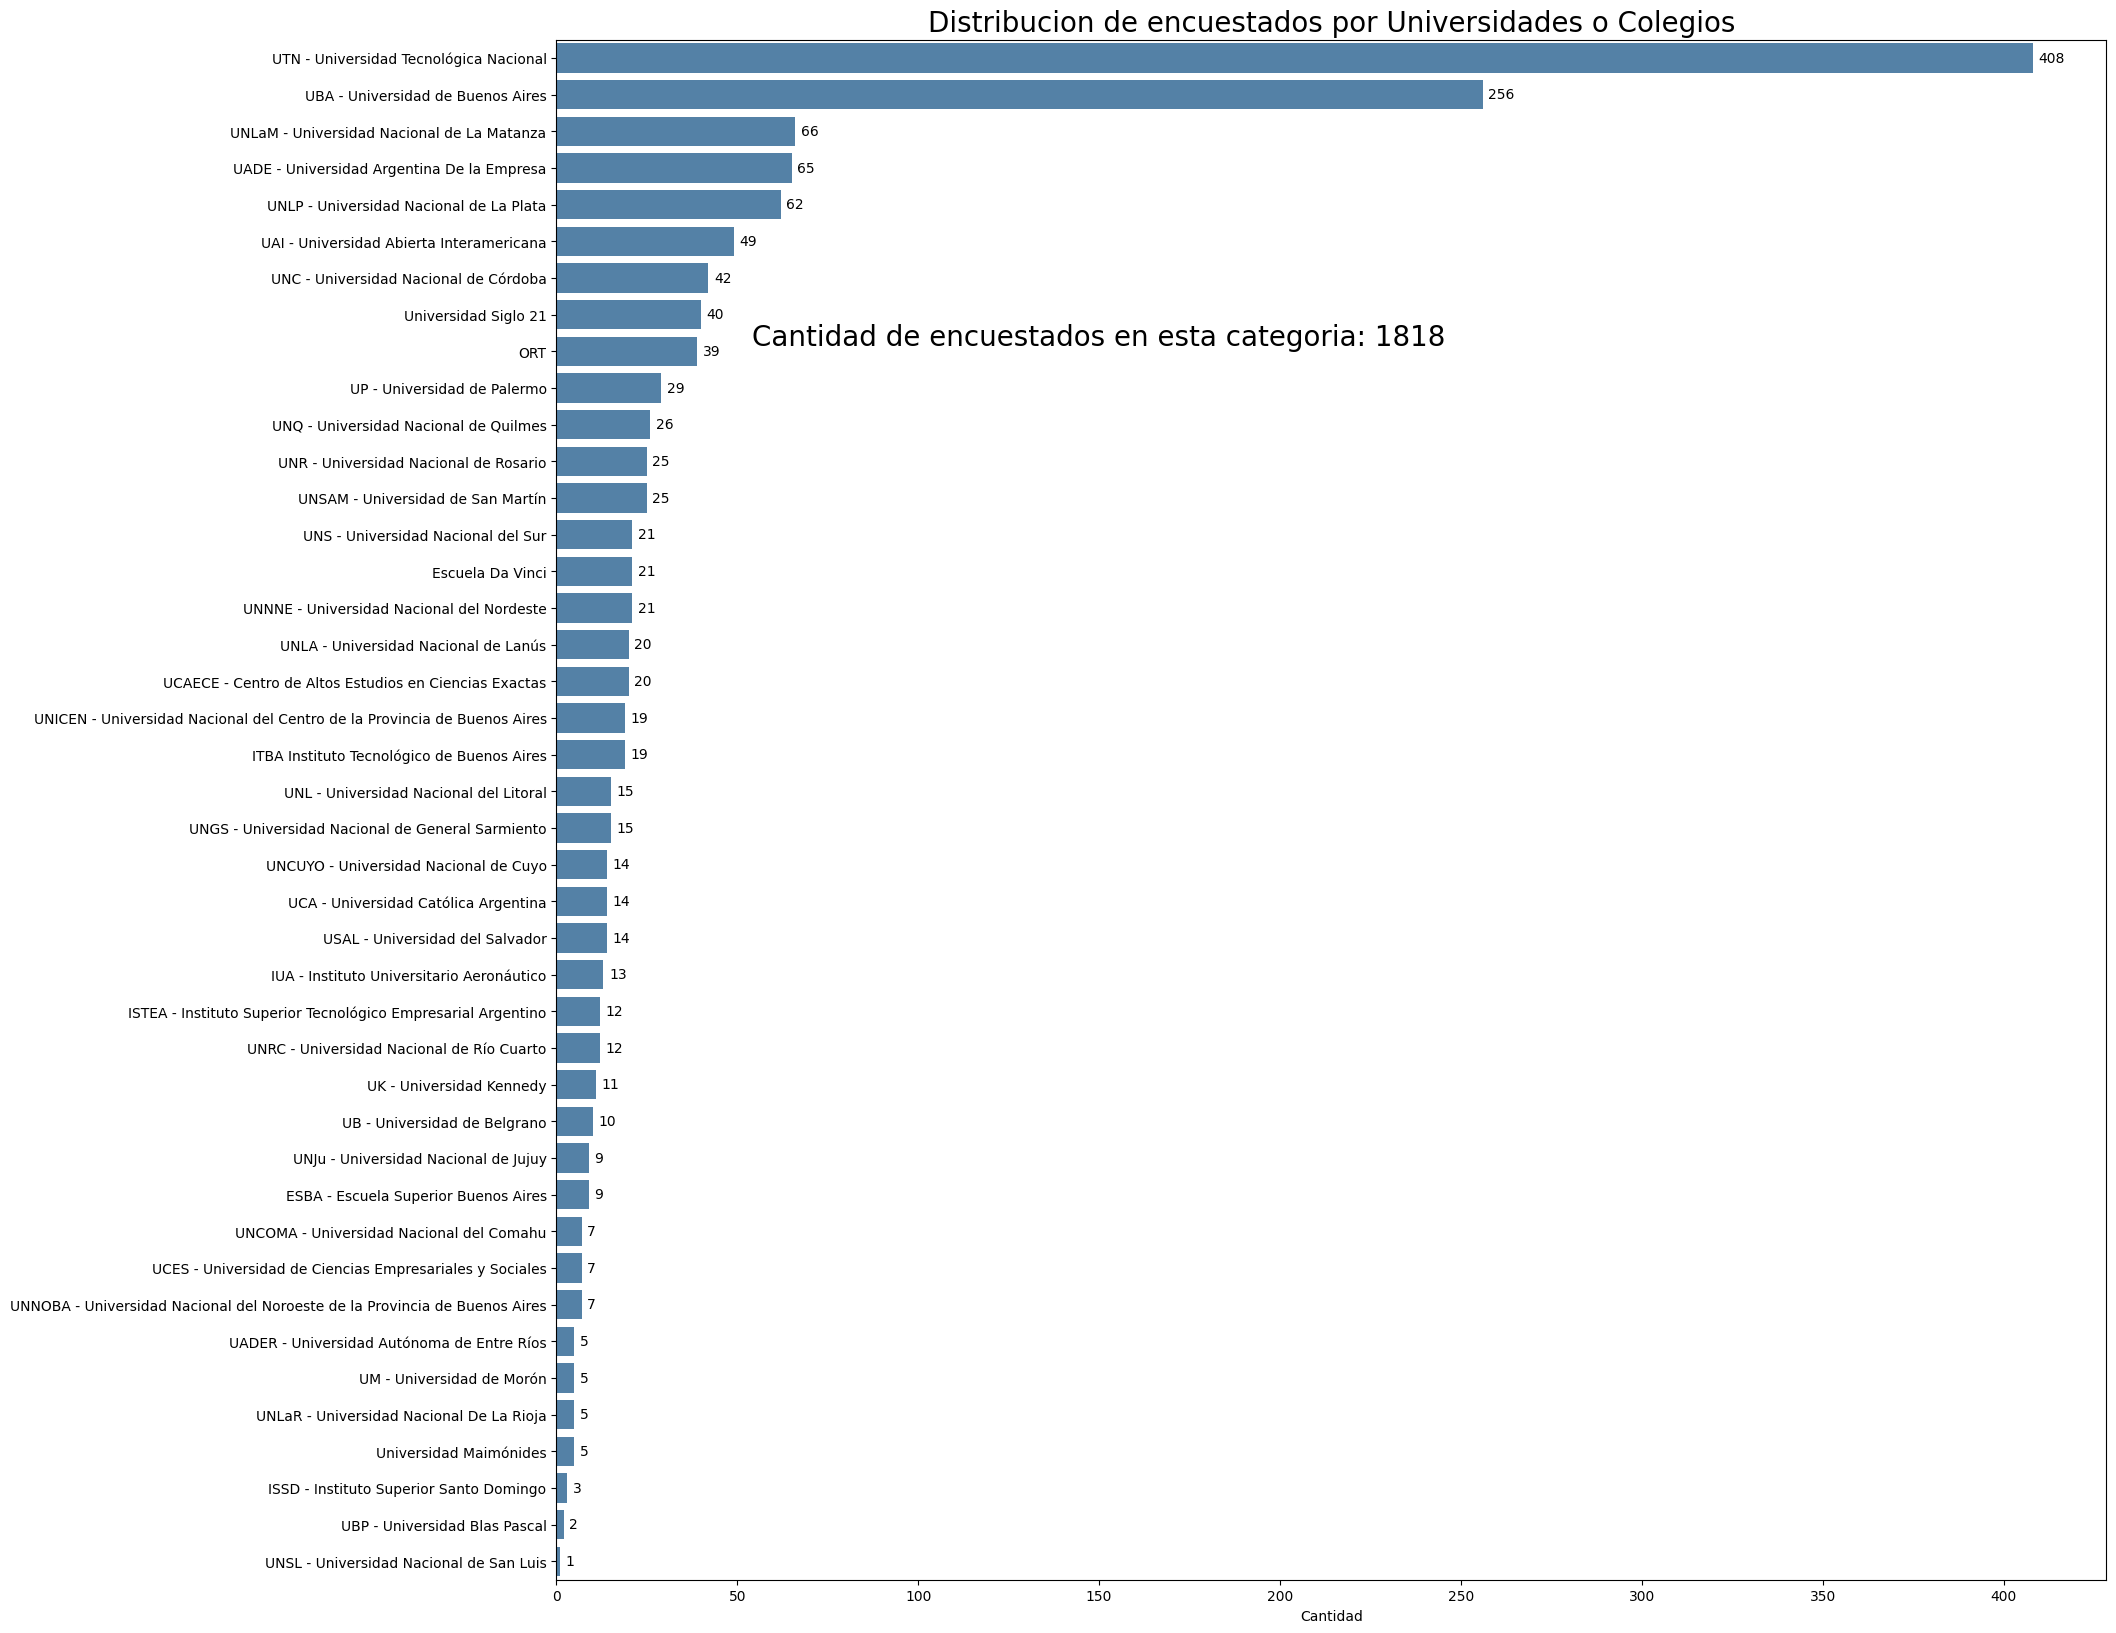

In [ ]:
#UNIVERSITY/SCHOOL
fig = plt.figure(figsize=(20, 20))
ax = sns.countplot(data=salaries[salaries["university/school"] != 'Prefiero no responder'], y="university/school", color='steelblue',
                  order=salaries[salaries["university/school"] != 'Prefiero no responder']["university/school"].value_counts().index)
plt.title("Distribucion de encuestados por Universidades o Colegios", fontsize=20)
plt.xlabel("Cantidad")
plt.ylabel('')
plt.yticks(fontsize=10)
ax.bar_label(ax.containers[0], padding=4)
ax.annotate('Cantidad de encuestados en esta categoria: ' + str((salaries['university/school'] != 'Prefiero no responder').sum()),
             (150, 8), ha='center', va='bottom', fontsize=20)

# EDA: ANALISIS MULTIVARIABLE

**RELACION ENTRE LA EDAD Y LOS AÑOS DE EXPERIENCIA**

Text(0, 0.5, '')

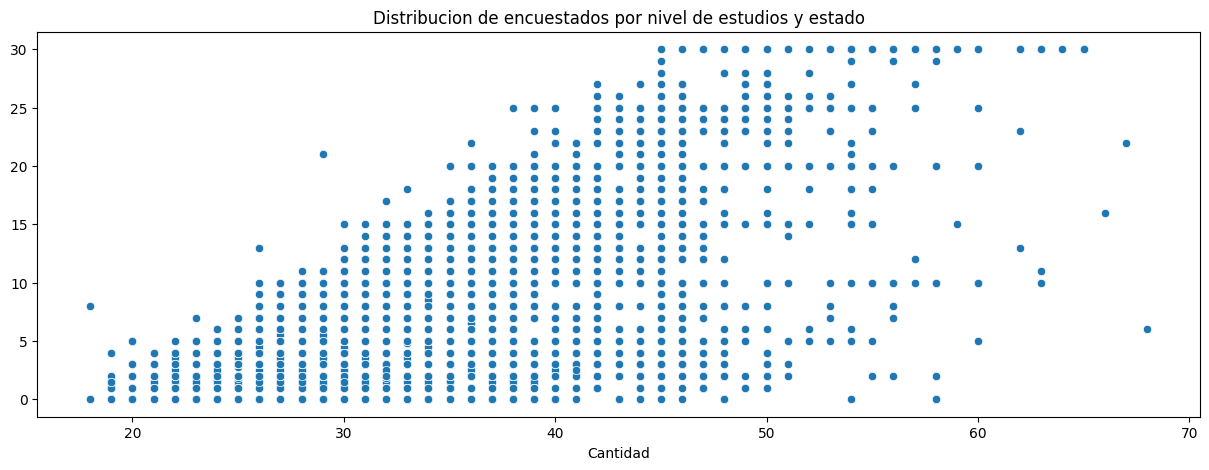

In [29]:
fig = plt.figure(figsize=(15, 5))
ax = sns.scatterplot(x = salaries[stats.zscore(salaries['age']) < 3]['age'], y = salaries[stats.zscore(salaries['years_experience']) < 3]['years_experience'])
plt.title("Distribucion de encuestados por nivel de estudios y estado",loc='center')
plt.xlabel("Cantidad")
plt.ylabel('')